# Fine-tuning a masked language model

Lets say I have a pretrained BERT model. My use-case is to assess market sentiment and gauge investor confidence by analyzing the sentiment of financial news articles, earnings reports, and other financial communications. However, base BERT does not have knowledge about financial terms.

**How will I proceed with my use-case using a language model?**

You will have to fine-tune the BERT model on past market insights data.



Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

# **Picking a pretrained model for masked language modeling**

Although the BERT and RoBERTa family of models are the most downloaded, we’ll use a model called DistilBERT that can be trained much faster with little to no loss in downstream performance.

Let’s go ahead and download DistilBERT using the AutoModelForMaskedLM class:

In [2]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [5]:
#Check and compare parameters of BERT and DistilBERT
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


In [6]:
text = "This is a great [MASK]."

As humans, we can imagine many possibilities for the [MASK] token, such as “day”, “ride”, or “painting”. For pretrained models, the predictions depend on the corpus the model was trained on, since it learns to pick up the statistical patterns present in the data. Like BERT, DistilBERT was pretrained on the English Wikipedia and BookCorpus datasets, so we expect the predictions for [MASK] to reflect these domains.

To predict the mask we need DistilBERT’s tokenizer to produce the inputs for the model

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

With a tokenizer and a model, we can now pass our text example to the model, extract the logits, and print out the top 5 candidates

In [8]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

#token_logits[0, mask_token_index, :] extracts the logits for the [MASK] token positions from the token_logits tensor.
# 0 selects the first (or only) sequence in the batch.
# mask_token_index provides the specific positions where [MASK] tokens are located.
# : selects the logits for all tokens in the vocabulary at those positions.


for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


To showcase domain adaptation, we’ll use the famous Large Movie Review Dataset (or IMDb for short), which is a corpus of movie reviews that is often used to benchmark sentiment analysis models. By fine-tuning DistilBERT on this corpus, we expect the language model will adapt its vocabulary from the factual data of Wikipedia that it was pretrained on to the more subjective elements of movie reviews.

In [9]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

#NOTE : we won’t need the labels for language modeling.

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [10]:
sample = imdb_dataset["train"].shuffle(seed=43).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: [WARNING: CONTAINS SPOILERS]<br /><br />I have this adult friend for whom the notion that her parents have sex makes her terribly uneasy. She came to mind when I reflected on the audience's reaction to "The Mother." <br /><br />People gasped when May (Anne Reid) writhed passionately in bed with her younger hunk lover, Darren (Daniel Craig) or later saw sexually explicit drawings by May. I doubt the audience was aghast at the nudity or the drawings' content as much as feeling uneasy at seeing a woman in her 60s rapturously enjoying sex.<br /><br />Screenwriter Hanif Kureishi ("My Beautiful Laundrette," "My Son the Fanatic") again proves why he's among the most trenchant storytellers on either side of the Atlantic. His story's not easy to take. This searing family drama isn't a film you can claim you enjoyed watching because it's raw, complex, and often makes us very uncomfortable. Nevertheless, it's powerfully good stuff.<br /><br />Kureishi and Roger Michell (who directed

Considering the input of length of the model, we usually truncate the text if it is too long.

**Do you think this truncation will affect the outcome of your language model?**

Yes, truncation will affect the outcome in terms of context.

We can avoid loss of context by converting the larger text into smaller parts and feeding them all to the model.

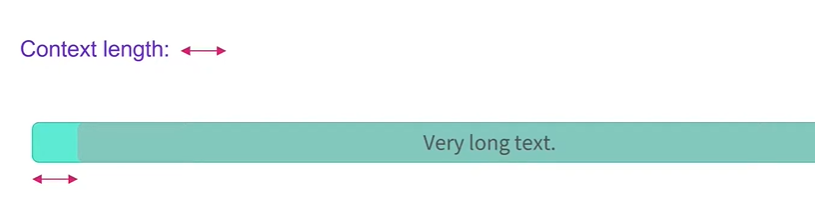

In [11]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

word_ids:

 This list maps each token to its corresponding word in the original input text. For example, if a word in your text is split into multiple tokens by the tokenizer, all those tokens will have the same word ID. If a token is a padding token, its word ID will be None.

Now that we’ve tokenized our movie reviews, the next step is to group them all together and split the result into chunks.

**But how big should these chunks be?**

The chunk size should be equal to the max length of the input that the model can handle.

In [14]:
tokenizer.model_max_length

512

In [15]:
# Lets pick something a bit smaller that can fit in memory of google colab
chunk_size = 128

In [16]:
def group_texts(examples):
    # Concatenate all texts
    # Write code: Combine all tokenized sequences into a single long sequence for each feature. For each key in the examples dictionary,
    # concatenate all the lists of tokens into one long list.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}

    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size

    # Split by chunks of max_len
    #Divide the concatenated sequence into chunks of the specified size.
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }

    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

**Write how you have dealt with the last chunk as it's length is not the same?**

I dropped the last chunk.

As you can see in this example, the last chunk will generally be smaller than the maximum chunk size. There are two main strategies for dealing with this:

* Drop the last chunk if it’s smaller than chunk_size.
* Pad the last chunk until its length equals chunk_size.


**Why did we create a new labels column which is a copy of the input_ids one?**

So that when we apply the masks, we can have an original list which will act as the ground truth.

Write what is the following map function doing!

In [17]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 122957
    })
})

**Hold on!**

**What is with this increase in dataset size?**

Because we concatenated the truncated chunks in the dataset. So the number of rows increase.

In [18]:
tokenizer.decode(lm_datasets["train"][50]["input_ids"])

'< br / > my last 2 cents : humorously enough, this movie was made by a movie company called brain damage films. they\'re brains must have really been damaged to come up with a craptacular movie like this. < br / > < br / > my rating : 1 out of 10 ( if it were up to me, this movie would get the rating of negative bajillion ) [SEP] [CLS] if the crew behind " zombie chronicles " ever read this, here\'s some advice guys : < br / > < br / > 1. in a " twist ending " - type movie, it\'s not'

**Since it is a language model, take a look at the data and suggest how should we proceed further?**

We will mask the data for training.

In [19]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

To see how the random masking works, let’s feed a few examples to the data collator. Since it expects a list of dicts, where each dict represents a single chunk of contiguous text, we first iterate over the dataset before feeding the batch to the collator.

In [20]:
# RUN THE FOLLOWING CODE
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i [MASK] i am curious - yellow from my video store because of all the controversy [MASK] [MASK] it when it was first released [MASK] 1967. i also [MASK] that [MASK] first it was seized by [MASK]. s. customs if it ever tried [MASK] enter this country, therefore being a fan of films considered " controversial [MASK] i really had [MASK] [MASK] this for myself. < [MASK] / > < br / [MASK] [MASK] plot [MASK] centered around [MASK] young [MASK] drama student [MASK] lena who [MASK] to learn everything she can [MASK] life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such'

'>>> as the [MASK] war and race [MASK] in the [MASK] states. in between asking politicians [MASK] ordinary denize [MASK] of [MASK] about their opinions on [MASK], she curious sex with her drama teacher, [MASK], and 1794 men. < br / > < [MASK] / > what kills me [MASK] i bk curious - [MASK] is that [MASK] years ag

Nice, it worked! We can see that the [MASK] token has been randomly inserted at various locations in our text. These will be the tokens which our model will have to predict during training — and the beauty of the data collator is that it will randomize the [MASK] insertion with every batch!

**Think of a disadvantage of random masking!**

When training models for masked language modeling, one technique that can be used is to mask whole words together, not just individual tokens. This approach is called whole word masking. If we want to use whole word masking, we will need to build a data collator ourselves. A data collator is just a function that takes a list of samples and converts them into a batch, so let’s do this now! We’ll use the word IDs computed earlier to make a map between word indices and the corresponding tokens, then randomly decide which words to mask and apply that mask on the inputs. Note that the labels are all -100 except for the ones corresponding to mask words.

**Search for the situations in which it would be preferable to use whole word masking.**

*Write your answer*

In [21]:
import collections
import numpy as np
from transformers import default_data_collator
wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [22]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] [MASK] rented i [MASK] curious - [MASK] from my video [MASK] because of [MASK] the controversy [MASK] surrounded it when it was first [MASK] in [MASK]. i [MASK] heard that at [MASK] it was seized by [MASK]. s. [MASK] if [MASK] [MASK] tried to enter [MASK] [MASK], therefore being a fan of films considered " controversial " i really had [MASK] see this [MASK] myself. < br [MASK] [MASK] < br / > the plot is centered around a [MASK] [MASK] drama student named lena who wants to [MASK] everything she can [MASK] life. in particular she wants to [MASK] her [MASK] [MASK] to making some sort of documentary on what the average swede thought about certain political [MASK] such'

'>>> as [MASK] [MASK] war and race [MASK] [MASK] [MASK] united states [MASK] in between asking politicians and ordinary denizens [MASK] stockholm about their opinions on [MASK] [MASK] she has sex with her drama teacher [MASK] classmates, and married men [MASK] < br / > < [MASK] / > what kills me about i am curi

We’ll first downsample the size of the training set to a few thousand examples.
 A quick way to downsample a dataset in 🤗 Datasets is via the Dataset.train_test_split()

In [23]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

The trainer and Training Arguments is a standard process!

In [24]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps=logging_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

One way to measure the quality of our language model is to calculate the probabilities it assigns to the next word in all the sentences of the test set. High probabilities indicates that the model is not “surprised” or “perplexed” by the unseen examples, and suggests it has learned the basic patterns of grammar in the language.

**Search for the relationship between perplexity and Cross entropy loss!**

In [26]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 21.94


In [ ]:
trainer.train()

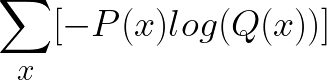

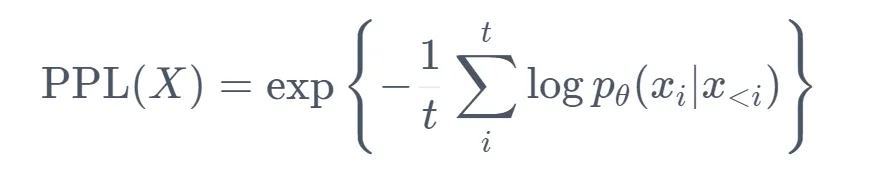

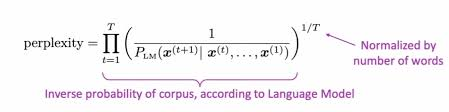

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

# **Fine-tuning DistilBERT with 🤗 Accelerate**

However, we saw that DataCollatorForLanguageModeling also applies random masking with each evaluation, so we’ll see some fluctuations in our perplexity scores with each training run. One way to eliminate this source of randomness is to apply the masking once on the whole test set, and then use the default data collator in 🤗 Transformers to collect the batches during evaluation. To see how this works, let’s implement a simple function that applies the masking on a batch, similar to our first encounter with DataCollatorForLanguageModeling

In [ ]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

Next, we’ll apply this function to our test set and drop the unmasked columns so we can replace them with the masked ones. You can use whole word masking by replacing the data_collator above with the appropriate one.

In [ ]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

We can then set up the dataloaders as usual, but we’ll use the default_data_collator from 🤗 Transformers for the evaluation set

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
output_dir = ""

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)

https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72

https://arxiv.org/abs/2203.00286#:~:text=Whole%20word%20masking%20(WWM)%2C,token%20is%20an%20atomic%20character.